<a href="https://colab.research.google.com/github/insjang/colab_ai/blob/main/kmooc/%5B%EA%B8%88%EC%9C%B5AI%5D_%EA%B8%B0%EB%A7%90%EA%B3%BC%EC%A0%9C_%EA%B0%90%EC%84%B1%EB%B6%84%EC%84%9D%EA%B3%BC%EC%A3%BC%EA%B0%80%EC%98%88%EC%B8%A1_insjang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 기말과제 - 감성분석과 주가예측
---
* 강좌명 : 금융 AI
* 이메일 : insjang@naver.com
---

# 1) 패키지 설치 및 불러오기


## 1.1. 패키지 설치
* VADER Sentiment (어휘 및 규칙기반 감정분석 도구)
* FinanceDataReader (야후금융 정보 조회)
* TextBlob (NLTK기반 텍스트 처리 도구)

In [ ]:
!pip install vaderSentiment
!pip install finance-datareader
!pip install textblob

## 1.2. 라이브러리 불러오기

In [2]:
import pandas as pd
import numpy as np
import math, re, warnings
from datetime import datetime
# 시각화, 자료리더기 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader as pdr
import FinanceDataReader as fdr

import nltk
from textblob import TextBlob
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


# 시각화 도구 기본 설정
plt.style.use('fivethirtyeight')
sns.set(style = 'white' , context = 'notebook', palette = 'deep')
#sns.set(rc={'figure.figsize':(11.7,8.27)})
warnings.filterwarnings('ignore', category = DeprecationWarning)
#pd.set_option('display.max_columns', None)

%matplotlib inline


---
# 2) 데이터 수집 및 취합

## 2.1. 수집 데이터 파일 업로드
1. 주식뉴스 CSV 파일 PC 다운로드 :  
Combined_News_DJIA.csv  
(http://www.kaggle.com/aaron7sun/stocknews)

2. 구글 드라이브에 업로드


In [ ]:
# COLAB에 뉴스 데이터 CSV 파일 업로드
from google.colab import files
files.upload()

In [ ]:
# 구글 드라이브 마운트
from google.colab import drive 
drive.mount('/content/drive/')

## 2.2. 수집데이터의 데이터프레임 가공

In [3]:
# 뉴스 데이터 가공
df1 = pd.read_csv('/content/drive/MyDrive/data/Combined_News_DJIA.csv') # 주식뉴스
df1['Date'] = pd.to_datetime(df1['Date']) # 'Date'필드 타입을 datetime형으로 변환
df1.set_index('Date', inplace=True) # 'Date' 필드를 인덱스로 정의
print(df1.head(2))

            Label  ...                                              Top25
Date               ...                                                   
2008-08-08      0  ...           b"No Help for Mexico's Kidnapping Surge"
2008-08-11      1  ...  b"So this is what it's come to: trading sex fo...

[2 rows x 26 columns]


In [4]:
# 주가 데이터 가공
sday = datetime(2008, 8, 8)
eday = datetime(2016, 7, 1)

dji = pdr.DataReader('^DJI', 'yahoo', sday, eday)  # DJIA (다우존스 산업평균지수)
snp = pdr.DataReader('^GSPC', 'yahoo', sday, eday) # S&P 500
df2 = pd.DataFrame({'DJ': dji['Close'], 'SP': snp['Close']}).dropna() # 주식 종가 
print(df2.head(2))

                      DJ           SP
Date                                 
2008-08-08  11734.320312  1296.319946
2008-08-11  11782.349609  1305.319946


In [5]:
# 뉴스 & 주가를 'Date'필드 기준으로 취합
merge = pd.merge(df1, df2, how='inner', on='Date', left_index=True)
merge.head(2)

,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,DJ,SP
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",11734.320312,1296.319946
2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",11782.349609,1305.319946


In [6]:
# 25개의 뉴스 필드들을 헤드라인 뉴스로 취합

headlines = []
for row in range(0, len(merge.index)) :
    headlines.append(' '.join(str(x) for x in merge.iloc[row, 1:26]))

clean_headlines = []
for i in range(0, len(headlines)) : # 불필요한 문자들 제거
    clean_headlines.append(re.sub("b[\'\"]+", '', headlines[i] ))
    clean_headlines[i] = re.sub("\'", '', clean_headlines[i] )

merge['Combined_News'] = clean_headlines
merge.head(2)

,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,DJ,SP,Combined_News
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",11734.320312,1296.319946,Georgia downs two Russian warplanes as countri...
2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",11782.349609,1305.319946,Why wont America and Nato help us? If they won...


---
# 3) 감성 분석 (Sentiment Analysis)

## 3.1. 주관성(Subjectivity), 극성(Polarity)

In [7]:
# 감성 분석(Sentiment Analysis)

def getSubjectivity(text): # 주관성
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text): # 극성
    return  TextBlob(text).sentiment.polarity

# 감성분석 후 'Subjectivity' & 'Polarity' 컬럼 추가
merge['Subjectivity'] = merge['Combined_News'].apply(getSubjectivity)
merge['Polarity'] = merge['Combined_News'].apply(getPolarity)
merge.head(2)

,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,DJ,SP,Combined_News,Subjectivity,Polarity
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",11734.320312,1296.319946,Georgia downs two Russian warplanes as countri...,0.267549,-0.048568
2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",11782.349609,1305.319946,Why wont America and Nato help us? If they won...,0.374806,0.121956


## 3.2.긍정(Positive), 부정(Negative), 중립(Neutral), 복합(Compound)

In [8]:
# 감성점수를 구함 (using Sentiment Intensity Analyzer)

def getSIA(text):
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(text)
    return sentiment

compound = []; neg = []; neu = []; pos = []
SIA = 0
for i in range(0, len(merge['Combined_News'])):
    SIA = getSIA(merge['Combined_News'][i])
    compound.append(SIA['compound']) # 복합
    neg.append(SIA['neg'])  # 부정
    pos.append(SIA['pos'])  # 긍정
    neu.append(SIA['neu'])  # 중립

merge['Compound'] = compound
merge['Negative'] = neg
merge['Positive'] = pos
merge['Neutral'] = neu
merge.head(2)

,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,DJ,SP,Combined_News,Subjectivity,Polarity,Compound,Negative,Positive,Neutral
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",11734.320312,1296.319946,Georgia downs two Russian warplanes as countri...,0.267549,-0.048568,-0.9982,0.235,0.041,0.724
2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",11782.349609,1305.319946,Why wont America and Nato help us? If they won...,0.374806,0.121956,-0.9858,0.191,0.089,0.721


---
# 4) 기초통계 및 상관관계

## 4.1. 기초통계 확인

In [10]:
df = merge[['Label', 'Subjectivity', 'Polarity', 
            'Compound', 'Negative', 'Neutral' ,'Positive']];
print(df.describe())

stats = df.describe()
stats.loc['var'] = df.var().tolist()    # 분산(Variance)
stats.loc['skew'] = df.skew().tolist()  # 왜도(Skewness)
stats.loc['kurt'] = df.kurtosis().tolist()   # 첨도(Kurtosis)
stats

             Label  Subjectivity  ...      Neutral     Positive
count  1989.000000   1989.000000  ...  1989.000000  1989.000000
mean      0.535445      0.361426  ...     0.772014     0.065675
std       0.498867      0.060884  ...     0.041818     0.020968
min       0.000000      0.161332  ...     0.588000     0.007000
25%       0.000000      0.321410  ...     0.746000     0.051000
50%       1.000000      0.361652  ...     0.773000     0.064000
75%       1.000000      0.400533  ...     0.802000     0.079000
max       1.000000      0.615242  ...     0.894000     0.153000

[8 rows x 7 columns]


,Label,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
count,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000
mean,0.535445,0.361426,0.022722,-0.957534,0.162320,0.772014,0.065675
std,0.498867,0.060884,0.053687,0.199241,0.038572,0.041818,0.020968
min,0.000000,0.161332,-0.225978,-0.999500,0.059000,0.588000,0.007000
25%,0.000000,0.321410,-0.011461,-0.996400,0.135000,0.746000,0.051000
50%,1.000000,0.361652,0.024870,-0.993200,0.159000,0.773000,0.064000
75%,1.000000,0.400533,0.057980,-0.985500,0.188000,0.802000,0.079000
max,1.000000,0.615242,0.195774,0.991700,0.316000,0.894000,0.153000
var,0.248869,0.003707,0.002882,0.039697,0.001488,0.001749,0.000440
skew,-0.142245,0.154518,-0.157040,7.471592,0.395967,-0.288086,0.457845


## 4.2. 상관관계 확인

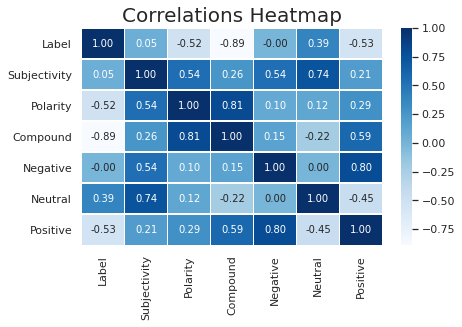

In [11]:
# 상관관계 Heatmap
ax = sns.heatmap(stats[1:].corr(), annot=True, fmt='.2f', linewidths=.5, cmap='Blues')
plt.title('Correlations Heatmap', fontsize=20)
plt.show() 

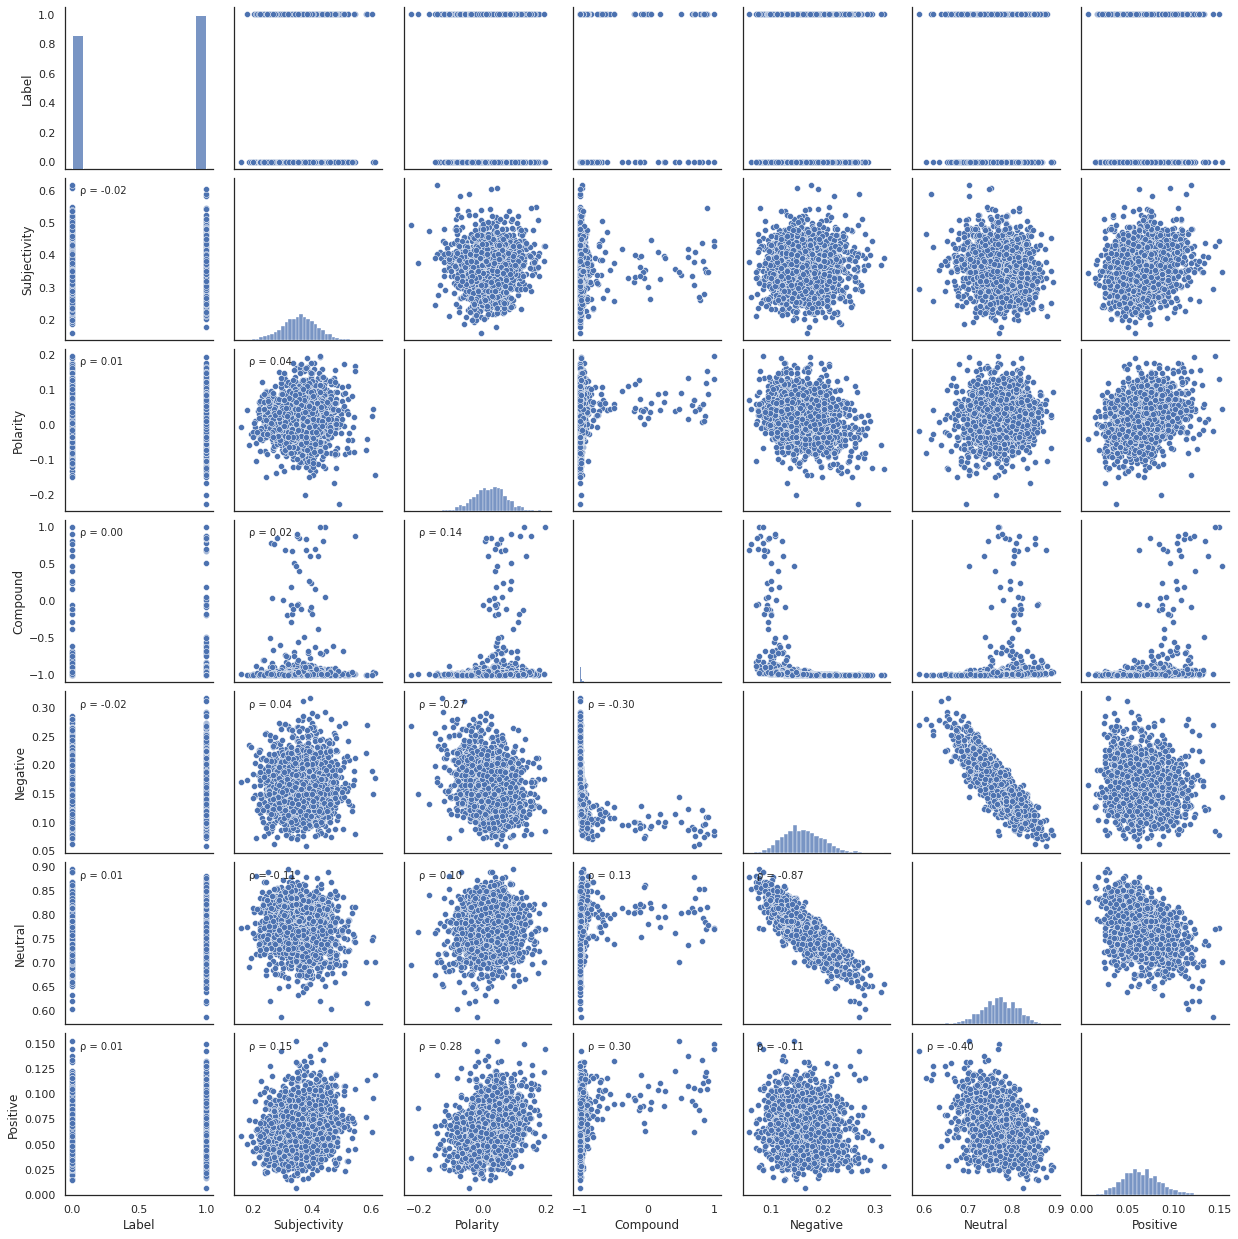

In [12]:
from scipy.stats import pearsonr
def corrfunc(x,y, ax=None, **kws):
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    rho = '\u03C1' # Unicode for lowercase rho (ρ)
    ax.annotate(f'{rho} = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

bx = sns.pairplot(df)
bx.map_lower(corrfunc)
plt.show() 

---
# 5) 머신 러닝 (Machine Learning)

## 5.1. 데이터 셋 생성

In [ ]:
from sklearn.model_selection import train_test_split

X = df  # 특성(feature) 데이터셋 생성
X = np.array(X.drop(['Label'], 1))

y = np.array(df['Label']) # 대상(target) 데이터셋 생성

# 80% 훈련 데이터셋과 20% 테스트 데이터셋으로 분할
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print('[ x_train:', len(x_train), '] x [ y_train:', len(y_train), ']')
print('==> [ x_test:', len(x_test), '] x [ y_test:', len(y_test), ']')

[ x_train: 1591 ] x [ y_train: 1591 ]
==> [ x_test: 398 ] x [ y_test: 398 ]


## 5.2. 분류기 성과 비교

In [ ]:
from sklearn.metrics import (confusion_matrix, classification_report) 
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score) 

def estimator_score(code, model, x_train, y_train, x_test, y_test) :
    model.fit(x_train, y_train.ravel())
    y_pred = model.predict(x_test)

    df = pd.DataFrame(columns=('model', 'type', 'score'))
    df.loc[code+'.ac'] = [code, 'accuracy', accuracy_score(y_test, y_pred)]
    df.loc[code+'.pc'] = [code, 'precison', precision_score(y_test, y_pred)]
    df.loc[code+'.rc'] = [code, 'recall'  , recall_score(y_test, y_pred)]
    df.loc[code+'.f1'] = [code, 'f1-score', f1_score(y_test, y_pred)]
    # Zero divide error 시 추가 : , average='weighted', labels=np.unique(y_pred)
    print('[ '+ code +' ] Classification report:')
    print(classification_report(y_test, y_pred))
    print('Accuracy of '+code+' classifier on test set: {:.5f}'.format(model.score(x_test, y_test)))
    print('---------------------------------------------------------')

    return df

### Linear Discriminant Analysis (LDA)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
score_lda = estimator_score('LDA', LinearDiscriminantAnalysis(), x_train, y_train, x_test, y_test)
print(score_lda)

[ LDA ] Classification report:
              precision    recall  f1-score   support

           0       0.17      0.01      0.01       193
           1       0.51      0.98      0.67       205

    accuracy                           0.51       398
   macro avg       0.34      0.49      0.34       398
weighted avg       0.34      0.51      0.35       398

Accuracy of LDA classifier on test set: 0.50503
---------------------------------------------------------
       model      type     score
LDA.ac   LDA  accuracy  0.505025
LDA.pc   LDA  precison  0.510204
LDA.rc   LDA    recall  0.975610
LDA.f1   LDA  f1-score  0.670017


### Logistic Regression (LGR)


In [ ]:
from sklearn.linear_model import LogisticRegression
score_lgr = estimator_score('LGR', LogisticRegression(), x_train, y_train, x_test, y_test)
print(score_lgr)

[ LGR ] Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       193
           1       0.51      0.99      0.67       205

    accuracy                           0.51       398
   macro avg       0.26      0.49      0.34       398
weighted avg       0.26      0.51      0.35       398

Accuracy of LGR classifier on test set: 0.50754
---------------------------------------------------------
       model      type     score
LGR.ac   LGR  accuracy  0.507538
LGR.pc   LGR  precison  0.511392
LGR.rc   LGR    recall  0.985366
LGR.f1   LGR  f1-score  0.673333


### Support Vector Classifier (SVC)

In [ ]:
from sklearn.svm import SVC
score_svc = estimator_score('SVC', SVC(), x_train, y_train, x_test, y_test)
print(score_svc)

[ SVC ] Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       193
           1       0.51      0.99      0.67       205

    accuracy                           0.51       398
   macro avg       0.26      0.49      0.34       398
weighted avg       0.26      0.51      0.35       398

Accuracy of SVC classifier on test set: 0.50754
---------------------------------------------------------
       model      type     score
SVC.ac   SVC  accuracy  0.507538
SVC.pc   SVC  precison  0.511392
SVC.rc   SVC    recall  0.985366
SVC.f1   SVC  f1-score  0.673333


### Stochastic Gradient Descent (SGD)

In [ ]:
from sklearn.linear_model import SGDClassifier
score_sgd = estimator_score('SGD', SGDClassifier(random_state=3224), x_train, y_train, x_test, y_test)
print(score_sgd)

[ SGD ] Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       193
           1       0.51      0.99      0.67       205

    accuracy                           0.51       398
   macro avg       0.26      0.49      0.34       398
weighted avg       0.26      0.51      0.35       398

Accuracy of SGD classifier on test set: 0.50754
---------------------------------------------------------
       model      type     score
SGD.ac   SGD  accuracy  0.507538
SGD.pc   SGD  precison  0.511392
SGD.rc   SGD    recall  0.985366
SGD.f1   SGD  f1-score  0.673333


### Quadratic Discriminant Analysis (QDA)

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
score_qda = estimator_score('QDA', QuadraticDiscriminantAnalysis(), x_train, y_train, x_test, y_test)
print(score_qda)

[ QDA ] Classification report:
              precision    recall  f1-score   support

           0       0.38      0.13      0.20       193
           1       0.49      0.80      0.61       205

    accuracy                           0.47       398
   macro avg       0.44      0.46      0.40       398
weighted avg       0.44      0.47      0.41       398

Accuracy of QDA classifier on test set: 0.47487
---------------------------------------------------------
       model      type     score
QDA.ac   QDA  accuracy  0.474874
QDA.pc   QDA  precison  0.493939
QDA.rc   QDA    recall  0.795122
QDA.f1   QDA  f1-score  0.609346


### K-Nearest Neighbors (KNN)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
score_knn = estimator_score('KNN', KNeighborsClassifier(), x_train, y_train, x_test, y_test)
print(score_knn)

[ KNN ] Classification report:
              precision    recall  f1-score   support

           0       0.50      0.46      0.48       193
           1       0.53      0.57      0.55       205

    accuracy                           0.52       398
   macro avg       0.52      0.52      0.52       398
weighted avg       0.52      0.52      0.52       398

Accuracy of KNN classifier on test set: 0.51759
---------------------------------------------------------
       model      type     score
KNN.ac   KNN  accuracy  0.517588
KNN.pc   KNN  precison  0.529412
KNN.rc   KNN    recall  0.570732
KNN.f1   KNN  f1-score  0.549296


## 5.3. 성과지표 결과 그래프

       model      type     score
LDA.ac   LDA  accuracy  0.505025
LDA.pc   LDA  precison  0.510204
LDA.rc   LDA    recall  0.975610
LDA.f1   LDA  f1-score  0.670017
LGR.ac   LGR  accuracy  0.507538
LGR.pc   LGR  precison  0.511392
LGR.rc   LGR    recall  0.985366
LGR.f1   LGR  f1-score  0.673333
SVC.ac   SVC  accuracy  0.507538
SVC.pc   SVC  precison  0.511392
SVC.rc   SVC    recall  0.985366
SVC.f1   SVC  f1-score  0.673333
SGD.ac   SGD  accuracy  0.507538
SGD.pc   SGD  precison  0.511392
SGD.rc   SGD    recall  0.985366
SGD.f1   SGD  f1-score  0.673333
QDA.ac   QDA  accuracy  0.474874
QDA.pc   QDA  precison  0.493939
QDA.rc   QDA    recall  0.795122
QDA.f1   QDA  f1-score  0.609346
KNN.ac   KNN  accuracy  0.517588
KNN.pc   KNN  precison  0.529412
KNN.rc   KNN    recall  0.570732
KNN.f1   KNN  f1-score  0.549296


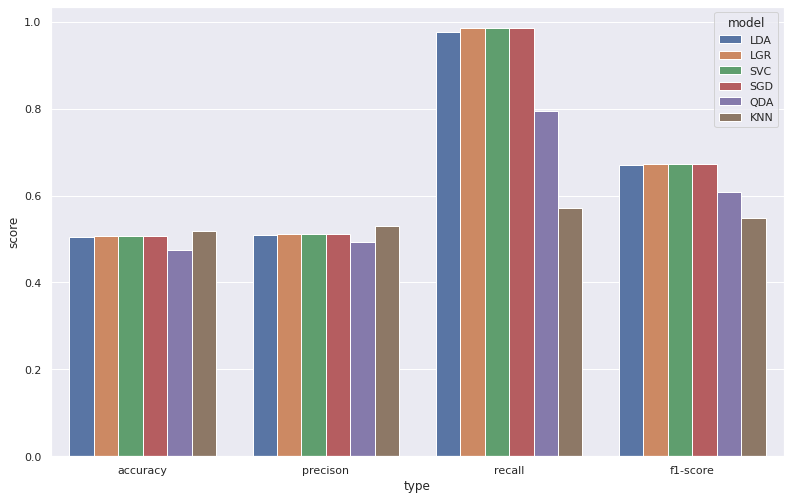

In [ ]:
# 분류 모형들의  성과지표 결과 취합
df_scores = pd.DataFrame(columns=('model', 'type', 'score'))

df_scores = df_scores.append(score_lda)
df_scores = df_scores.append(score_lgr)
df_scores = df_scores.append(score_svc)
df_scores = df_scores.append(score_sgd)
df_scores = df_scores.append(score_qda)
df_scores = df_scores.append(score_knn)

print(df_scores)

# 바차트에 비교 전시
sns.set(rc={'figure.figsize':(11.7,8.27)})
sx = sns.barplot(data=df_scores, x='type', y='score',  hue='model')
plt.show()

## 5.4. 성과척도별 분류기 비교

### 분류기 평가 모듈 클래스

In [ ]:
class MyClassifierEvaluation :
    def __init__(self, code, model) :
        self.code = code
        self.model = model
        #self.df_result = pd.DataFrame(columns=['Actual', 'Predicted'])
        #self.df_scores = pd.DataFrame(columns=['model', 'period', 'type', 'score'])

    def get_model(self) :
        return self.model

    def get_prices_since(self, df, date_since, period) :
        pos = df.index.get_loc(date_since)
        return df.iloc[pos - period : pos]

    def learn(self, df, ys, sday, eday, period=20) :
        model = self.get_model()
        df_result = pd.DataFrame(columns=['Actual', 'Predicted'])
        for day in df[sday:eday].index :
            # 모델 훈련
            x_trn = self.get_prices_since(df, day, period)
            y_trn = self.get_prices_since(ys, day, period)
            model.fit(x_trn, y_trn.ravel())
            
            # 현재 예측값
            x_curr = df.loc[day].values
            [y_pred] = model.predict([x_curr])

            # 일별 [실제값,예측값] 저장
            new_idx = pd.to_datetime(day, format='%Y-%m-%d')
            y_real = ys.loc[day]
            df_result.loc[new_idx] = [y_real, y_pred]

        # 성과지표 저장
        test_lst = np.array(df_result['Actual']).tolist()
        pred_lst = np.array(df_result['Predicted']).tolist()
        #print(test_lst, len(test_lst)); print(pred_lst, len(pred_lst))

        df_scores = pd.DataFrame(columns=['model', 'period', 'type', 'score'])
        mkey = self.code+str(period)
        df_scores.loc[mkey+'.ac'] = [self.code, period, 'accuracy', accuracy_score(test_lst, pred_lst)]
        df_scores.loc[mkey+'.pc'] = [self.code, period, 'precison', precision_score(test_lst, pred_lst)]
        df_scores.loc[mkey+'.rc'] = [self.code, period, 'recall'  , recall_score(test_lst, pred_lst)]
        df_scores.loc[mkey+'.f1'] = [self.code, period, 'f1-score', f1_score(test_lst, pred_lst)]

        return df_result, df_scores

# 클래스 단위테스트
#cms = MyClassifierEvaluation('SVC', SVC())
#df_result, df_scores = cms.learn(df.drop(['Label'], 1), df['Label'], '2014', '2016', 20)
#df_scores


### Lookback Period 변화에 따른 성과 비교

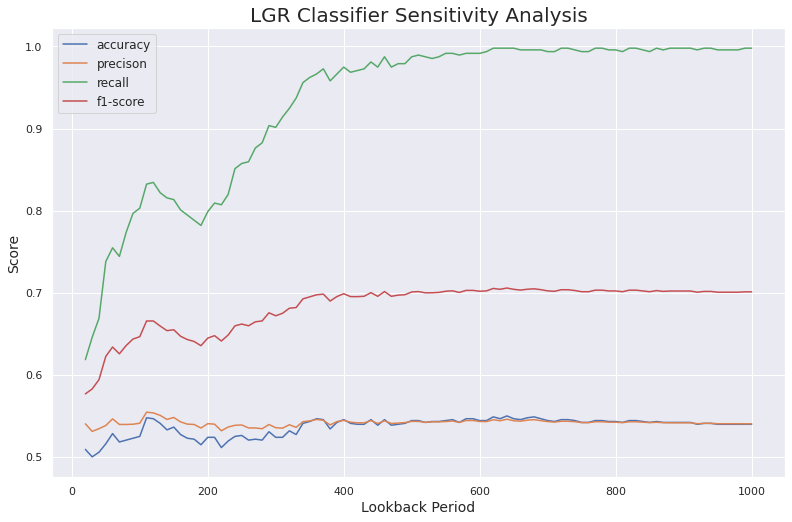

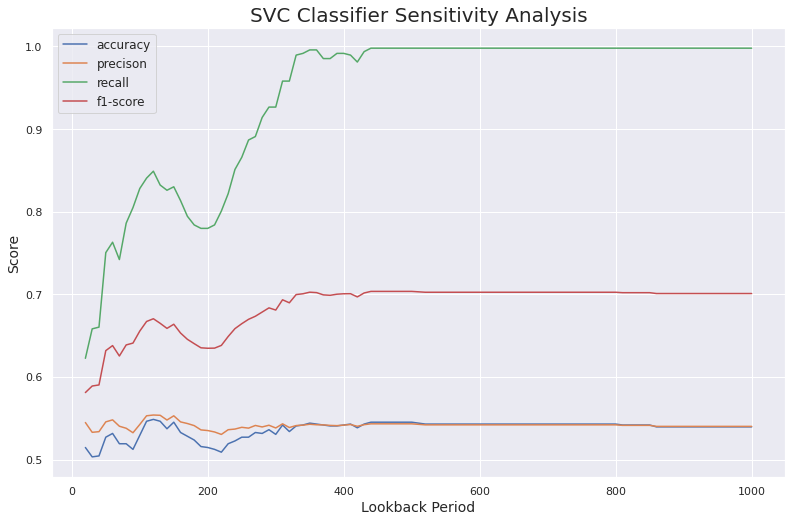

In [ ]:

models = [{ 'code' : 'LGR', 'model' : LogisticRegression() },
          { 'code' : 'SVC', 'model' : SVC() }]

for vo in models :
    df_all = pd.DataFrame(columns=['model', 'period', 'type', 'score'])
    runner = MyClassifierEvaluation(vo['code'], vo['model'])
    for idx in range(20, 1010, 10) :
        df_result, df_scores = runner.learn(df.drop(['Label'], 1), df['Label'], '2013', '2016', idx)
        df_all = df_all.append(df_scores)

    for gname in ['accuracy', 'precison', 'recall', 'f1-score'] :
        df_sub = df_all[df_all['type'] == gname]
        plt.plot(df_sub.period, df_sub.score)

    plt.title(vo['code']+' Classifier Sensitivity Analysis', fontsize=20)
    plt.xlabel('Lookback Period', fontsize=14)
    plt.ylabel('Score', fontsize=14)
    #plt.ylim([0.0, 1.0])
    plt.legend(['accuracy', 'precison', 'recall', 'f1-score'], fontsize=12, loc='best')
    plt.show()
    

---
### 기타 (Kaggle Titanic Competitions)

In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, x, y, ylim=None, cv=None,
						n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
	plt.figure();
	plt.title(title)
	plt.xlabel("Training examples"); plt.ylabel("Score")
	if ylim is not None: plt.ylim(*ylim)

	trn_cnt, trn_scores, tst_scores = learning_curve(
		estimator, x, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

	trn_avg = np.mean(trn_scores, axis=1); trn_std = np.std(trn_scores, axis=1)
	tst_avg = np.mean(tst_scores, axis=1); tst_std = np.std(tst_scores, axis=1)
	plt.grid()

	plt.fill_between(trn_cnt, trn_avg-trn_std, trn_avg+trn_std, alpha=0.1, color="r")
	plt.fill_between(trn_cnt, tst_avg-tst_std, tst_avg+tst_std, alpha=0.1, color="g")
	plt.plot(trn_cnt, trn_avg, 'o-', color="r", label="Training score")
	plt.plot(trn_cnt, tst_avg, 'o-', color="g", label="Cross-validation score")
	plt.legend(loc="best")
	return plt


---
# 6) 참고자료
* [Stock Market Sentiment Analysis Using Python & Machine Learning : randerson112358](https://randerson112358.medium.com/stock-market-sentiment-analysis-using-python-machine-learning-5b644f151a3e)
* [Github : innat > Kaggle-Play > Titanic Competition](https://github.com/innat/Kaggle-Play/tree/gh-pages/Titanic%20Competition)
* [Solving A Simple Classification Problem with Python — Fruits Lovers’ Edition : Susan Li](https://towardsdatascience.com/solving-a-simple-classification-problem-with-python-fruits-lovers-edition-d20ab6b071d2)
